# Load data

In [1]:
import pandas as pd
from constants import NULLABLE_MEASURES
from utils.class_patient import Patients

patients = Patients.loadPatients()
patients.fillMissingMeasureValue(NULLABLE_MEASURES, 0)

# Remove missing data

## Remove features with more than 20% missing

In [2]:
# remove measures with less than 80% of data

measures = patients.getMeasures()

for measure, count in measures.items():
    if count < len(patients) * 80 / 100:
        patients.removeMeasures([measure])
        print(measure, count)

pco2 917
ph 954
po2 917
albumin 406
hba1c 326
lymphocyte 446
height 415
urine-ketone 294
crp 19


## Remove patients with more than 20% missing features

In [3]:
patients.removePatientByMissingFeatures()
len(patients)

1206

## Display insight

In [4]:
# dfData = patients.getMeasuresBetween(pd.Timedelta(hours=-6), pd.Timedelta(hours=24), "first")

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(patients.getMeasures())

Counter({'age': 1206,
         'chronic_pulmonary_disease': 1206,
         'ckd_stage': 1206,
         'congestive_heart_failure': 1206,
         'dka_type': 1206,
         'gender': 1206,
         'history_aci': 1206,
         'history_ami': 1206,
         'hypertension': 1206,
         'liver_disease': 1206,
         'macroangiopathy': 1206,
         'malignant_cancer': 1206,
         'mechanical_ventilation': 1206,
         'microangiopathy': 1206,
         'oasis': 1206,
         'preiculos': 1206,
         'race': 1206,
         'saps2': 1206,
         'sofa': 1206,
         'use_NaHCO3': 1206,
         'uti': 1206,
         'ag': 1205,
         'bg': 1205,
         'bicarbonate': 1205,
         'bun': 1205,
         'chloride': 1205,
         'egfr': 1205,
         'hr': 1205,
         'potassium': 1205,
         'scr': 1205,
         'sodium': 1205,
         'dbp': 1204,
         'gcs': 1204,
         'gcs_unable': 1204,
         'rr': 1204,
         'sbp': 1204,
         'calci

In [5]:
akdCount = sum([p.akdPositive for p in patients.patientList])

akdCount / len(patients)

0.39303482587064675

# Machine learning

In [6]:
from constants import CATEGORICAL_MEASURES


idColumns = ["subject_id", "hadm_id", "stay_id"]
categoryColumns = CATEGORICAL_MEASURES
labelColumn = "akd"

## Split train-test

In [7]:
splitedPatients = patients.split(5, 27)


def trainTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        yield trainPatients, testPatients


def trainValTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        *trainPatients, valPatients = trainPatients.split(5, 27)
        tmpPatients = Patients(patients=[])
        for trainPatientsElem in trainPatients:
            tmpPatients += trainPatientsElem
        trainPatients = tmpPatients

        yield trainPatients, valPatients, testPatients

## Define model

In [8]:
from GRANDE import GRANDE


how = "first"

def createModel():
    import os

    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

    params = {
        "depth": 6,  # tree depth
        "n_estimators": 1000,  # number of estimators / trees
        "learning_rate_weights": 0.005,  # learning rate for leaf weights
        "learning_rate_index": 0.01,  # learning rate for split indices
        "learning_rate_values": 0.01,  # learning rate for split values
        "learning_rate_leaf": 0.01,  # learning rate for leafs (logits)
        "optimizer": "adam",  # optimizer
        "cosine_decay_steps": 0,  # decay steps for lr schedule (CosineDecayRestarts)
        "loss": "crossentropy",  # loss function (default 'crossentropy' for binary & multi-class classification and 'mse' for regression)
        "focal_loss": False,  # use focal loss {True, False}
        "temperature": 0.0,  # temperature for stochastic re-weighted GD (0.0, 1.0)
        "from_logits": True,  # use logits for weighting {True, False}
        "use_class_weights": True,  # use class weights for training {True, False}
        "dropout": 0.0,  # dropout rate (here, dropout randomly disables individual estimators of the ensemble during training)
        "selected_variables": 0.8,  # feature subset percentage (0.0, 1.0)
        "data_subset_fraction": 1.0,  # data subset percentage (0.0, 1.0)
    }

    args = {
        "device": "gpu",  # device {'cpu', 'gpu'}
        "epochs": 1_000,  # number of epochs for training
        "early_stopping_epochs": 25,  # patience for early stopping (best weights are restored)
        "batch_size": 64,  # batch size for training
        "cat_idx": [],  # put list of categorical indices
        "objective": "binary",  # objective / task {'binary', 'classification', 'regression'}
        "random_seed": 42,
        "verbose": 0,
    }

    return GRANDE(params=params, args=args)

createModel()

2024-07-15 18:38:14.396673: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-15 18:38:14.418122: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-15 18:38:14.718033: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<GRANDE name=grande, built=False>

`functionize-notebook` has modified this notebook during execution. The following variables have been injected:

- how: last


## Without validate

### Without fill missing data

In [10]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from utils.prepare_data import normalizeData


accuracy_score_list = []
precision_score_list = []
recall_score_list = []
auc_score_list = []
for trainPatients, testPatients in trainTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, _ = normalizeAndFillData(dfTrain, dfTest)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train)

    # y_pred = model.predict(X_test)
    y_pred_proba = model.predict(X_test)[:, 1]  # For AUC

    accuracy_score_list.append(accuracy_score(y_test, np.round(y_pred_proba)))
    precision_score_list.append(precision_score(y_test, np.round(y_pred_proba)))
    recall_score_list.append(recall_score(y_test, np.round(y_pred_proba)))
    auc_score_list.append(roc_auc_score(y_test, y_pred_proba))

NameError: name 'normalizeAndFillData' is not defined

In [11]:

print(f"Average AUC: {np.mean(auc_score_list)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list)}")
print(f"Average Precision: {np.mean(precision_score_list)}")
print(f"Average Recall: {np.mean(recall_score_list)}")

Average AUC: nan
Average Accuracy: nan
Average Precision: nan
Average Recall: nan


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### Fill missing with knn

In [12]:
from sklearn.metrics import roc_auc_score
from utils.prepare_data import normalizeAndFillData


accuracy_score_list_knn = []
precision_score_list_knn = []
recall_score_list_knn = []
auc_score_list_knn = []
for trainPatients, valPatients, testPatients in trainValTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfVal = valPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfVal = dfVal.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, dfVal = normalizeData(dfTrain, dfTest, dfVal)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_val = dfVal.drop(columns=[labelColumn])  # type: ignore
    y_val = dfVal[labelColumn]  # type: ignore

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    X_train = X_train.fillna(0)
    X_val = X_val.fillna(0)
    X_test = X_test.fillna(0)

    model = createModel()
    model.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)

    # y_pred = model.predict(X_test)
    y_pred_proba = model.predict(X_test)[:, 1]  # For AUC

    accuracy_score_list_knn.append(accuracy_score(y_test, np.round(y_pred_proba)))
    precision_score_list_knn.append(precision_score(y_test, np.round(y_pred_proba)))
    recall_score_list_knn.append(recall_score(y_test, np.round(y_pred_proba)))
    auc_score_list_knn.append(roc_auc_score(y_test, y_pred_proba))

2024-07-05 19:27:20.406750: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-05 19:27:20.426326: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [13]:

print(f"Average AUC: {np.mean(auc_score_list_knn)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_knn)}")
print(f"Average Precision: {np.mean(precision_score_list_knn)}")
print(f"Average Recall: {np.mean(recall_score_list_knn)}")

Average AUC: 0.8065402190574492
Average Accuracy: 0.748750042865471
Average Precision: 0.6938280782069074
Average Recall: 0.6518924972004478


## With validate

### Without fill missing data

In [14]:
from utils.prepare_data import normalizeData


accuracy_score_list_val = []
precision_score_list_val = []
recall_score_list_val = []
auc_score_list_val = []
for trainPatients, valPatients, testPatients in trainValTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfVal = valPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfVal = dfVal.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, dfVal = normalizeData(dfTrain, dfTest, dfVal)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_val = dfVal.drop(columns=[labelColumn]) # type: ignore
    y_val = dfVal[labelColumn] # type: ignore

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)

    # y_pred = model.predict(X_test)
    y_pred_proba = model.predict(X_test)[:, 1]  # For AUC

    accuracy_score_list_val.append(accuracy_score(y_test, np.round(y_pred_proba)))
    precision_score_list_val.append(precision_score(y_test, np.round(y_pred_proba)))
    recall_score_list_val.append(recall_score(y_test, np.round(y_pred_proba)))
    auc_score_list_val.append(roc_auc_score(y_test, y_pred_proba))

In [15]:


print(f"Average AUC: {np.mean(auc_score_list_val)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_val)}")
print(f"Average Precision: {np.mean(precision_score_list_val)}")
print(f"Average Recall: {np.mean(recall_score_list_val)}")

Average AUC: 0.8065402190574492
Average Accuracy: 0.748750042865471
Average Precision: 0.6938280782069074
Average Recall: 0.6518924972004478


### Fill missing with knn

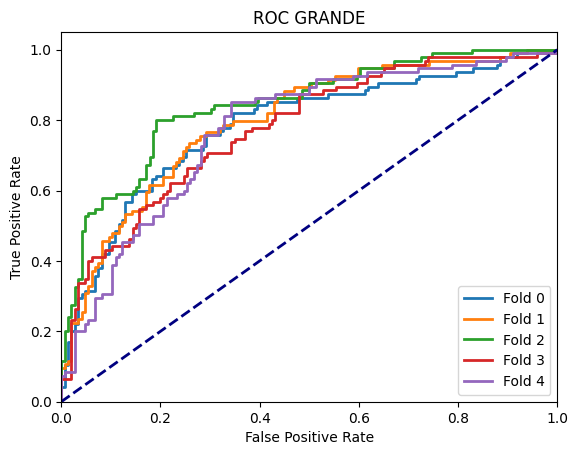

In [11]:
from sklearn.metrics import roc_auc_score
from utils.prepare_data import normalizeAndFillData
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from matplotlib import pyplot as plt
import numpy as np


accuracy_score_list_val_knn = []
precision_score_list_val_knn = []
recall_score_list_val_knn = []
auc_score_list_val_knn = []
metric_dic_list_val_knn = []

plt.figure()
for i, (trainPatients, valPatients, testPatients) in enumerate(trainValTest()):
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfVal = valPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfVal = dfVal.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, dfVal = normalizeAndFillData(dfTrain, dfTest, dfVal)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_val = dfVal.drop(columns=[labelColumn])  # type: ignore
    y_val = dfVal[labelColumn]  # type: ignore

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)

    # y_pred = model.predict(X_test)
    y_pred_proba = model.predict(X_test)[:, 1]  # For AUC

    accuracy_score_list_val_knn.append(accuracy_score(y_test, np.round(y_pred_proba)))
    precision_score_list_val_knn.append(precision_score(y_test, np.round(y_pred_proba)))
    recall_score_list_val_knn.append(recall_score(y_test, np.round(y_pred_proba)))
    auc_score_list_val_knn.append(roc_auc_score(y_test, y_pred_proba))

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, lw=2, label=f"Fold {i}")

plt.plot([0, 1], [0, 1], linestyle="--", color="navy", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC GRANDE")
plt.legend(loc="lower right")
plt.show()

In [17]:
print(f"Average AUC: {np.mean(auc_score_list_val_knn)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_val_knn)}")
print(f"Average Precision: {np.mean(precision_score_list_val_knn)}")
print(f"Average Recall: {np.mean(recall_score_list_val_knn)}")

Average AUC: 0.8106612640607638
Average Accuracy: 0.748756901340832
Average Precision: 0.6977234713260121
Average Recall: 0.6413885778275477


### Param tune 

In [18]:
# from sklearn.base import BaseEstimator, ClassifierMixin
# from sklearn.model_selection import train_test_split


# class GRANDEWrapper(BaseEstimator, ClassifierMixin):
#     def __init__(self, **kwargs):
#         self.params = kwargs
#         self.args = {
#             "device": "gpu",  # device {'cpu', 'gpu'}
#             "epochs": 1_000,  # number of epochs for training
#             "early_stopping_epochs": 25,  # patience for early stopping (best weights are restored)
#             "batch_size": 64,  # batch size for training
#             "cat_idx": [],  # put list of categorical indices
#             "objective": "binary",  # objective / task {'binary', 'classification', 'regression'}
#             "random_seed": 42,
#             "verbose": 0,
#         }
#         self.model = None

#     def set_params(self, **params):
#         for key, value in params.items():
#             self.params[key] = value
#         return self

#     def get_params(self, deep=True):
#         return self.params

#     def fit(self, X, y):
#         self.classes_ = np.unique(y)

#         X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=self.args["random_seed"])

#         self.model = GRANDE(params=self.params, args=self.args)
#         self.model.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)
#         return self

#     def predict(self, X):
#         if self.model is None:
#             raise Exception("Model has not been trained yet!")
#         return self.model.predict(X)

#     def predict_proba(self, X):
#         if self.model is None:
#             raise Exception("Model has not been trained yet!")
#         return self.model.predict(X)

#     def score(self, X, y):
#         y_pred_proba = self.predict_proba(X)[:, 1]  # For binary classification
#         return roc_auc_score(y, y_pred_proba)

In [19]:
# from sklearn.model_selection import GridSearchCV
# from utils.prepare_data import normalizeData


# paramGrid = {
#     "params__device"
#     "params__depth": [4, 6, 8],
#     "params__n_estimators": [500, 1000, 1500],
#     "params__learning_rate_weights": [0.001, 0.005, 0.01],
#     "params__learning_rate_index": [0.005, 0.01, 0.05],
#     "params__learning_rate_values": [0.005, 0.01, 0.05],
#     "params__learning_rate_leaf": [0.005, 0.01, 0.05],
#     "params__optimizer": ["adam", "sgd"],
#     "params__cosine_decay_steps": [0, 100, 500],
#     "params__loss": ["crossentropy", "mse"],
#     "params__focal_loss": [True, False],
#     "params__temperature": [0.0, 0.1, 0.5],
#     "params__from_logits": [True, False],
#     "params__use_class_weights": [True, False],
#     "params__dropout": [0.0, 0.1, 0.5],
#     "params__selected_variables": [0.6, 0.8, 1.0],
#     "params__data_subset_fraction": [0.8, 1.0],
# }


# gridModel = GRANDEWrapper()
# gridSearch = GridSearchCV(
#     estimator=gridModel,
#     param_grid=paramGrid,
#     scoring="roc_auc",
#     cv=5,
#     verbose=2,
#     n_jobs=3,
# )

# dfAll = patients.getMeasuresBetween(
#     pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
# )
# dfAll = dfAll.drop(columns=idColumns)
# dfAll, _, _ = normalizeData(dfAll, dfAll)
# X_all = dfAll.drop(columns=[labelColumn])
# y_all = dfAll[labelColumn]

# gridSearch.fit(X_all, y_all)

# print("Params", gridSearch.best_params_)
# print("Scores", gridSearch.best_score_)